In [1]:

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from torch.nn import functional as F

import time
import math

import matplotlib.pyplot as plt

In [2]:

torch.manual_seed(1560)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(torch.__version__)
device



2.2.0


device(type='cuda', index=0)

In [4]:
def create_data_loader(batch_size):
  # Split the provided CIFAR-10 train set (50,000 images) into your train and val sets
  # Use the first 40,000 images as your train set and the remaining 10,000 images as val set
  # Use all 10,000 images in the provided test set as your test set

  transform = transforms.Compose([
    transforms.ToTensor(),
      # This is the mean and the average of the cifar db because we are normalizing it.
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), 
  ])

  # load cifar
  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # split train set into train and val
  train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])

  # create data loaders
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=32)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True,num_workers=32)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True,num_workers=32)

  train_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
  val_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]
  test_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in test_loader]


  return train_loader, val_loader, test_loader

In [5]:
class AddEpsilon(nn.Module):
    def __init__(self, epsilon=1e-10): # 1e-10 is smallest possible float in pytorch
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x + self.epsilon

    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x 

In [6]:
def init_train_var(model):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

  return criterion, optimizer

In [7]:
def test(model_path, test_loader):
  # use the provided test loader
  # return the test accuracy
  model = torch.load(model_path)
  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    test_acc = correct / total
  return test_acc


In [8]:
BATCH_SIZE = 128
train_loader, val_loader, test_loader = create_data_loader(batch_size=BATCH_SIZE)


model = Net()
# model = torch.compile(model)
# model = nn.DataParallel(model)
model = model.to(device)
# model = model.module.to(device)
criterion, optimizer = init_train_var(model)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/anaconda3/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
EPOCH_COUNT = 60

In [10]:
%%time

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCH_COUNT):
    model.train()
    train_loss = 0
    train_correct = 0
    # for each batch
    for i, (inputs, labels) in enumerate(train_loader):
        # count the number of weights with very small magnitute < 1e-3
        nans_count = 0
        for param in model.parameters():
            if param.grad is not None:
                nans_count += torch.sum(torch.isnan(param.grad)).item()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print all gradients of the first synapse
        # print(f"synapse grads : {model.classifier[-1].synapses[0][0].main[0].grad}")
        # print(f"weights of first layer {model.classifier[-1].synapses[0][0]}")
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()


    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_correct/40000:.4f}')
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct/40000)

    # validate
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
    val_acc = val_correct/10000
    print(f'Epoch {epoch+1}/{EPOCH_COUNT}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    



Epoch 1/60, Train Loss: 685.6687, Train Accuracy: 0.1974
Epoch 1/60, Val Loss: 160.4736, Val Accuracy: 0.2807
Epoch 2/60, Train Loss: 606.7497, Train Accuracy: 0.3085
Epoch 2/60, Val Loss: 147.4292, Val Accuracy: 0.3334
Epoch 3/60, Train Loss: 570.0761, Train Accuracy: 0.3527
Epoch 3/60, Val Loss: 139.2948, Val Accuracy: 0.3755
Epoch 4/60, Train Loss: 537.1277, Train Accuracy: 0.3898
Epoch 4/60, Val Loss: 131.3996, Val Accuracy: 0.4074
Epoch 5/60, Train Loss: 509.3089, Train Accuracy: 0.4192
Epoch 5/60, Val Loss: 125.5725, Val Accuracy: 0.4338
Epoch 6/60, Train Loss: 489.9577, Train Accuracy: 0.4394
Epoch 6/60, Val Loss: 121.7181, Val Accuracy: 0.4521
Epoch 7/60, Train Loss: 476.7833, Train Accuracy: 0.4575
Epoch 7/60, Val Loss: 119.1260, Val Accuracy: 0.4631
Epoch 8/60, Train Loss: 467.0708, Train Accuracy: 0.4708
Epoch 8/60, Val Loss: 117.1836, Val Accuracy: 0.4730
Epoch 9/60, Train Loss: 459.0575, Train Accuracy: 0.4814
Epoch 9/60, Val Loss: 115.5986, Val Accuracy: 0.4821
Epoch 10/6

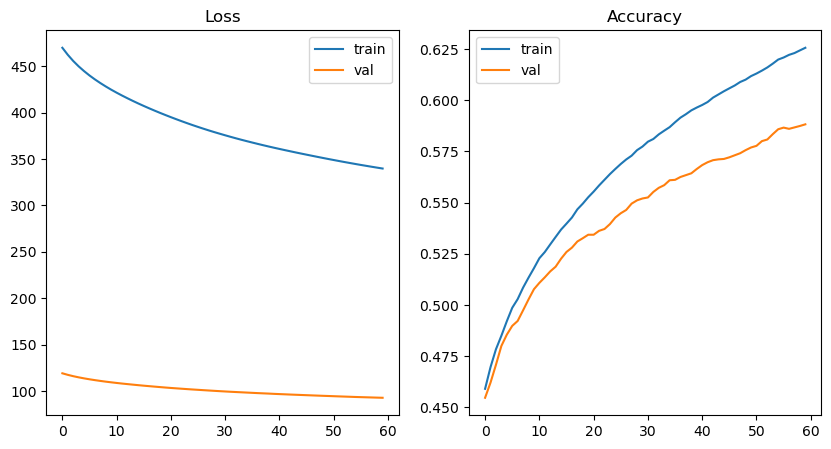

In [14]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='val')
plt.title('Accuracy')
plt.legend()


# save plot to storage
plt.savefig(f"experiment_{EXPERIMENT_ID}_plot.png")

plt.show()

# save model to storage
torch.save(model, f"experiment_{EXPERIMENT_ID}_model.pth")

In [ ]:
# print weights and powers of quasi poly layer

quasi_poly_layer = model.classifier[-1]
for i in range(quasi_poly_layer.out_features):
    for j in range(quasi_poly_layer.in_features):
        print(f'QuasiPolySynapse {i} {j} power: {quasi_poly_layer.synapses[i][j].power.item()}')
        print(f'QuasiPolySynapse {i} {j} term weights: {quasi_poly_layer.synapses[i][j].term_weights.data}')
        

